In [1]:
import mediapipe as mp

In [3]:
! pip install scikit-learn

  Using cached scikit_learn-1.6.1-cp39-cp39-win_amd64.whl (11.2 MB)
     -------------------------------------- 309.1/309.1 KB 6.4 MB/s eta 0:00:00
  Using cached threadpoolctl-3.6.0-py3-none-any.whl (18 kB)


You should consider upgrading via the 'C:\Users\Morvica\OneDrive\Desktop\Morvica\isl_words\isl_words_env\Scripts\python.exe -m pip install --upgrade pip' command.


In [4]:
import os
import cv2
import numpy as np
import mediapipe as mp

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split


In [5]:
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(
    static_image_mode=False,
    max_num_hands=2,
    min_detection_confidence=0.6,
    min_tracking_confidence=0.6
)


In [19]:
def extract_landmarks(video_path):
    cap = cv2.VideoCapture(video_path)
    sequence = []

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = hands.process(frame)

        keypoints = []

        for i in range(2):
            if results.multi_hand_landmarks and i < len(results.multi_hand_landmarks):
                for lm in results.multi_hand_landmarks[i].landmark:
                    keypoints.extend([lm.x, lm.y])
            else:
                keypoints.extend([0.0] * 42)

        sequence.append(keypoints)

    cap.release()
    return np.array(sequence)


In [7]:
MAX_LEN = 30

def pad_sequence(seq):
    if len(seq) >= MAX_LEN:
        return seq[:MAX_LEN]
    else:
        pad = np.zeros((MAX_LEN - len(seq), seq.shape[1]))
        return np.vstack([seq, pad])


In [8]:
def augment_sequence(seq):
    # 1️⃣ small gaussian noise
    noise = np.random.normal(0, 0.01, seq.shape)
    seq = seq + noise

    # 2️⃣ temporal jitter (drop or repeat frame)
    if np.random.rand() < 0.5:
        idx = np.random.randint(1, len(seq)-1)
        seq = np.delete(seq, idx, axis=0)
        seq = pad_sequence(seq)

    return seq


In [11]:
DATA_PATH = "data/raw_videos"
WORDS = sorted(os.listdir(DATA_PATH))
LABEL_MAP = {w:i for i,w in enumerate(WORDS)}

X, y = [], []

for word in WORDS:
    folder = os.path.join(DATA_PATH, word)
    for video in os.listdir(folder):
        path = os.path.join(folder, video)

        seq = extract_landmarks(path)
        seq = pad_sequence(seq)

        # original
        X.append(seq)
        y.append(LABEL_MAP[word])

        # augmented
        X.append(augment_sequence(seq))
        y.append(LABEL_MAP[word])

X = np.array(X)
y = to_categorical(y, num_classes=len(WORDS))

print("X:", X.shape, "y:", y.shape)


X: (334, 30, 168) y: (334, 8)


In [12]:
X = (X - np.mean(X, axis=1, keepdims=True)) / (
     np.std(X, axis=1, keepdims=True) + 1e-6
)


In [13]:
labels = np.argmax(y, axis=1)

X_train, X_val, y_train_lbl, y_val_lbl = train_test_split(
    X, labels,
    test_size=0.2,
    stratify=labels,
    random_state=42
)

y_train = to_categorical(y_train_lbl, num_classes=len(WORDS))
y_val   = to_categorical(y_val_lbl, num_classes=len(WORDS))


In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.optimizers import Adam

model = Sequential([
    Bidirectional(
        LSTM(64, return_sequences=False),
        input_shape=(30, 168)
    ),

    Dense(64, activation='relu'),
    Dropout(0.4),

    Dense(len(WORDS), activation='softmax')
])

model.compile(
    optimizer=Adam(1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 128)              119296    
 l)                                                              
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 8)                 520       
                                                                 
Total params: 128,072
Trainable params: 128,072
Non-trainable params: 0
_________________________________________________________________


In [15]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=20,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=10
    )
]

history = model.fit(
    X_train, y_train,
    epochs=150,
    batch_size=4,
    validation_data=(X_val, y_val),
    shuffle=True,
    callbacks=callbacks
)


Epoch 1/150
67/67 [==============================] - 4s 20ms/step - loss: 1.8044 - accuracy: 0.2996 - val_loss: 1.4554 - val_accuracy: 0.3881 - lr: 0.0010
Epoch 2/150
67/67 [==============================] - 1s 9ms/step - loss: 1.2622 - accuracy: 0.5581 - val_loss: 1.0085 - val_accuracy: 0.6716 - lr: 0.0010
Epoch 3/150
67/67 [==============================] - 1s 9ms/step - loss: 0.9446 - accuracy: 0.6891 - val_loss: 0.8192 - val_accuracy: 0.6716 - lr: 0.0010
Epoch 4/150
67/67 [==============================] - 1s 9ms/step - loss: 0.6812 - accuracy: 0.7416 - val_loss: 0.7940 - val_accuracy: 0.6716 - lr: 0.0010
Epoch 5/150
67/67 [==============================] - 1s 9ms/step - loss: 0.5240 - accuracy: 0.8277 - val_loss: 0.5831 - val_accuracy: 0.8060 - lr: 0.0010
Epoch 6/150
67/67 [==============================] - 1s 9ms/step - loss: 0.4070 - accuracy: 0.8764 - val_loss: 0.4371 - val_accuracy: 0.7910 - lr: 0.0010
Epoch 7/150
67/67 [==============================] - 1s 9ms/step - loss: 0.

In [16]:
model.save("isl_bilstm_best.h5")

In [17]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

y_true = np.argmax(y_val, axis=1)
y_pred = np.argmax(model.predict(X_val), axis=1)

print(classification_report(y_true, y_pred, target_names=WORDS))
print(confusion_matrix(y_true, y_pred))

3/3 [==============================] - 0s 5ms/step
              precision    recall  f1-score   support

        cold       1.00      1.00      1.00         8
        cool       1.00      1.00      1.00         8
       happy       1.00      1.00      1.00         8
         hot       1.00      1.00      1.00         8
        loud       1.00      1.00      1.00         9
         new       1.00      0.78      0.88         9
       quiet       0.89      1.00      0.94         8
        warm       0.80      0.89      0.84         9

    accuracy                           0.96        67
   macro avg       0.96      0.96      0.96        67
weighted avg       0.96      0.96      0.95        67

[[8 0 0 0 0 0 0 0]
 [0 8 0 0 0 0 0 0]
 [0 0 8 0 0 0 0 0]
 [0 0 0 8 0 0 0 0]
 [0 0 0 0 9 0 0 0]
 [0 0 0 0 0 7 0 2]
 [0 0 0 0 0 0 8 0]
 [0 0 0 0 0 0 1 8]]


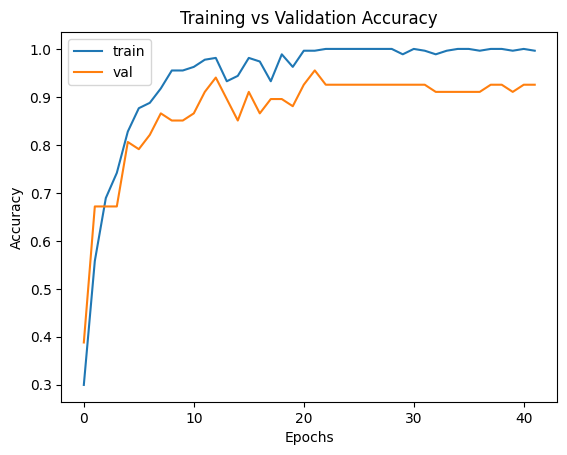

In [18]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.show()